<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/Copy_of_%5BAIDL_Winter_25%5D_CV_lab_04_Semantic_Segmentation_TODO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

**Notebook created by David Anglada Rotger for the course [Aprenentatge per Reforç i Aprenentatge Profund](https://www.upc.edu/content/grau/guiadocent/pdf/cat/230817) in [GCED](https://dse.upc.edu/ca) (2023).** Based on the tutorial
by Shivam Chandhok.

# Initializations and imports

In [1]:
!pip install torch torchvision
!pip install matplotlib
!pip install opencv-contrib-python
!pip install imutils
!pip install scikit-learn
!pip install tqdm

For this lab, we are going to use a dataset from the repository [U-Net: Semantic segmentation with PyTorch - Custom dataset](https://github.com/ajithvallabai/UNet-Pytorch-Customdataset). We are going to clone the repository and unzip de data. Also, we need to create a folder to store the output.

In [2]:
!git clone https://github.com/ajithvallabai/UNet-Pytorch-Customdataset.git

Cloning into 'UNet-Pytorch-Customdataset'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 53 (delta 15), reused 44 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 24.21 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
cd UNet-Pytorch-Customdataset/

/content/UNet-Pytorch-Customdataset


In [4]:
!unzip data.zip

Archive:  data.zip
   creating: data/imgs/
  inflating: data/imgs/0.jpg         
  inflating: data/imgs/1.jpg         
  inflating: data/imgs/10.jpg        
  inflating: data/imgs/1000.jpg      
  inflating: data/imgs/1001.jpg      
  inflating: data/imgs/1002.jpg      
  inflating: data/imgs/1003.jpg      
  inflating: data/imgs/1004.jpg      
  inflating: data/imgs/1005.jpg      
  inflating: data/imgs/1006.jpg      
  inflating: data/imgs/1007.jpg      
  inflating: data/imgs/1008.jpg      
  inflating: data/imgs/1009.jpg      
  inflating: data/imgs/1010.jpg      
  inflating: data/imgs/1011.jpg      
  inflating: data/imgs/1012.jpg      
  inflating: data/imgs/1013.jpg      
  inflating: data/imgs/1014.jpg      
  inflating: data/imgs/1015.jpg      
  inflating: data/imgs/1016.jpg      
  inflating: data/imgs/1017.jpg      
  inflating: data/imgs/1018.jpg      
  inflating: data/imgs/1019.jpg      
  inflating: data/imgs/1020.jpg      
  inflating: data/imgs/1021.jpg      
  infla

In [5]:
cd /content

/content


In [6]:
!mkdir output

In [7]:
# import the necessary packages
import torch
import os
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
import torch.nn as nn
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [8]:
# base path of the dataset
DATASET_PATH = os.path.join("/content", "UNet-Pytorch-Customdataset", "data")
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "imgs")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

print(IMAGE_DATASET_PATH)

/content/UNet-Pytorch-Customdataset/data/imgs


# Definition of the problem

The problem that we are going to face is to segment the flooded area of an image. Hence, we are facing a semantic segmentation problem with two classes: non-flooded and flooded area.

To solve the problem, we are going to define a UNet model and train it from scratch.

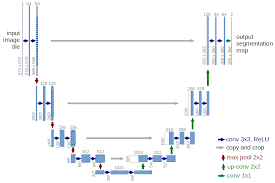

In the following cell, we have an example of a sample of the dataset and its correspondand ground truth mask.

(600, 800, 3)


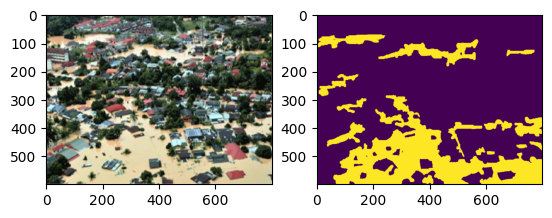

In [9]:
img = plt.imread(os.path.join(IMAGE_DATASET_PATH, "0.jpg"))
mask = plt.imread(os.path.join(MASK_DATASET_PATH, "0.png"))
print(img.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(mask)

# Global Variables definition

In [10]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 4
# define the input image dimensions
INPUT_IMAGE_WIDTH = 800
INPUT_IMAGE_HEIGHT = 600
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_flood_area.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# Exercise 1: Dataset class definition

In the following cell, we are going to define the class for our segmentation dataset. In this class, we define how we read the images and their masks andwe apply the preprocessing transformation. Use the function `cv2.imread()` [(documentation)](https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/). The mask, has to be read in **gray scale** (use `cv2.imread(_, 0)`).



In [11]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # TODO: grab the image path from the current index
        imagePath = self.imagePaths[idx]

        # TODO: load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # return a tuple of the image and its mask
        return (image, mask)

# Exercise 2: Define the Convolutional Block

Now we are going to define the UNet model. First, we define the convolutional block that is going to be applied in each level. This block is composed by:

- A convolutional layer with input `inChannels` and output channels `outChannels`, with a 3x3 kernel.
- A ReLU activation function.
- Another convolutional layer with input `inChannels` and output channels `outChannels`, with a 3x3 kernel.

Complete both the layers and the `forward()` step.

In [24]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(Block, self).__init__()
        # TODO: create the convolution and RELU layers
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)

    def forward(self, x):
        # TODO: apply CONV => RELU => CONV block to the inputs and return it
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)

        return x

# Exercise 3: Define the Encoder of the UNet.

Now we are going to define the Encoder of the UNet using the Convolutional Block that we have just defined.

Define a **MaxPooling Layer** with a 2x2 kernel to be applied after each Convolutional Block. Complete the `forward()` step, taking into account that, in the UNet, we have to store all the outputs of all the blocks to build the **Skip Connections** in the Decoder.

In [25]:
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64)):
            super().__init__()
            # TODO: create the encoder blocks and maxpooling layer
            self.encBlocks = nn.ModuleList([
                Block(channels[i], channels[i + 1])
                for i in range(len(channels) - 1)
            ])
            self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # TODO: loop through the encoder blocks and update the blockOutputs list
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)

        return blockOutputs

# Exercise 4: Define de Decoder

Once we have defined the Encoder, we have to define our Decoder. We are also going to use the convolutional block previously defined, and we are going to build the Skip Connections with the output of the blocks of the encoder. Remeber that, in the UNet, before the convolutional blocks, we use Transposed Convolution to "unpool" the features and be able to recover the desired spatial definition.

- Define the `ModuleList()` of Transposed Convolutional Layers with `ConvTransposed2d()`, with the specified `channels`, 2x2 kernel and stride = 2. Get inspired by how it's done in the Encoder.
- Define the `ModuleList()` of Convolutional Blocks. Get inspired by how it's done in the Encoder.
- Complete the `forward()` step, using `torch.cat()` to concatenate the Encoder Features (`encFeat`) to the output of the upsampling operation.

In [26]:
import torch
import torch.nn as nn
from torch.nn import ModuleList
from torchvision.transforms import CenterCrop

class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
          super().__init__()
          # TODO: initialize the number of channels, upsampler blocks, and decoder blocks
          self.upconvs = nn.ModuleList()
          for i in range(len(channels) - 1):
              self.upconvs.append(nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2))
          self.dec_blocks = nn.ModuleList()
          for i in range(len(channels) - 1):
              self.dec_blocks.append(Block(channels[i+1] * 2, channels[i+1]))

    def forward(self, x, encFeatures):
      # loop through the number of channels
        for i in range(len(self.upconvs)):
            x = self.upconvs[i](x)
            # TODO: crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = encFeatures[-(i + 2)] # Access encoder features in reverse order
            encFeat = self.crop(encFeat, x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)

        # return the final decoder output
        return x

    def crop(self, encFeatures, x):
          # grab the dimensions of the inputs, and crop the encoder
          # features to match the dimensions
          (_, _, H, W) = x.shape
          encFeatures = CenterCrop([H, W])(encFeatures)
          # return the cropped features
          return encFeatures

# Exercise 5: Define the UNet

Finally, we are going to combine the Encoder and the Decoder in the final UNet model.

- Define the Encoder and the Decoder using the defined modules.
- Complete the `forward()` step.

In [27]:
class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
          decChannels=(64, 32, 16),
          nbClasses=1, retainDim=True,
          outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):

        super().__init__()
        # TODO: initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        # initialize the regression head and store the class variables
        self.head = nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # TODO: grab the features from the encoder
        encFeatures = self.encoder(x)

        # TODO: pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures)

        # TODO: pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)

        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
          map = F.interpolate(map, self.outSize)

        # return the segmentation map
        return map

# Exercise 6: Build the datasets.

Here, we are defining the datasets that we are going to use to train our model.

- First, use the function `train_test_split()` from sci-kit learn ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) to create the train and test partition. The test size is defined in the variable `TEST_SPLIT`. Use `random_state=42`.

- Define the train and test datasets (`trainDS` and `testDS`) using the class `SegmentationDataset` defined before.

In [28]:
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

# TODO: partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
# DO NOT CHANGE THE random_state
split = train_test_split(imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [29]:
trans = transforms.Compose([transforms.ToPILImage(),
        transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
        transforms.ToTensor()])

# TODO: create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=trans)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=trans)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
    batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
    num_workers=os.cpu_count())

[INFO] found 246 examples in the training set...
[INFO] found 44 examples in the test set...


# Exercise 7: Define the train loop

- Initialize the model
- Define the loss function. We are going to use the BCELoss combined with a sigmoid layer. Use the `BCEWithLogitsLoss()` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)).
- Define the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with learning rate `INIT_LR`.
- Complete the training loop.

In [30]:
# TODO: initialize our UNet model
unet = UNet()
unet = unet.to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [31]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # TODO: perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)

        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Add the loss to the total training loss
        totalTrainLoss += loss

    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
              # send the input to the device
              (x, y) = (x.to(DEVICE), y.to(DEVICE))
              # make the predictions and calculate the validation loss
              pred = unet(x)
              totalTestLoss += lossFunc(pred, y)
        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgTestLoss = totalTestLoss / testSteps
        # update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
        print("Train loss: {:.6f}, Test loss: {:.4f}".format(
          avgTrainLoss, avgTestLoss))
        # display the total time needed to perform the training
        endTime = time.time()
        print("[INFO] total time taken to train the model: {:.2f}s".format(
        endTime - startTime))

[INFO] training the network...


  5%|▌         | 1/20 [00:13<04:09, 13.12s/it]

[INFO] EPOCH: 1/20
Train loss: 0.608881, Test loss: 0.4832
[INFO] total time taken to train the model: 13.13s


 10%|█         | 2/20 [00:26<03:59, 13.31s/it]

[INFO] EPOCH: 2/20
Train loss: 0.531775, Test loss: 0.4576
[INFO] total time taken to train the model: 26.56s


 15%|█▌        | 3/20 [00:40<03:49, 13.49s/it]

[INFO] EPOCH: 3/20
Train loss: 0.499171, Test loss: 0.4634
[INFO] total time taken to train the model: 40.27s


 20%|██        | 4/20 [00:53<03:33, 13.37s/it]

[INFO] EPOCH: 4/20
Train loss: 0.486439, Test loss: 0.4485
[INFO] total time taken to train the model: 53.46s


 25%|██▌       | 5/20 [01:06<03:18, 13.26s/it]

[INFO] EPOCH: 5/20
Train loss: 0.481762, Test loss: 0.3890
[INFO] total time taken to train the model: 66.51s


 30%|███       | 6/20 [01:19<03:03, 13.08s/it]

[INFO] EPOCH: 6/20
Train loss: 0.449459, Test loss: 0.4392
[INFO] total time taken to train the model: 79.25s


 35%|███▌      | 7/20 [01:32<02:49, 13.01s/it]

[INFO] EPOCH: 7/20
Train loss: 0.434488, Test loss: 0.4220
[INFO] total time taken to train the model: 92.12s


 40%|████      | 8/20 [01:45<02:36, 13.02s/it]

[INFO] EPOCH: 8/20
Train loss: 0.457387, Test loss: 0.4666
[INFO] total time taken to train the model: 105.16s


 45%|████▌     | 9/20 [01:58<02:23, 13.02s/it]

[INFO] EPOCH: 9/20
Train loss: 0.433988, Test loss: 0.3974
[INFO] total time taken to train the model: 118.17s


 50%|█████     | 10/20 [02:11<02:09, 12.98s/it]

[INFO] EPOCH: 10/20
Train loss: 0.438037, Test loss: 0.3695
[INFO] total time taken to train the model: 131.05s


 55%|█████▌    | 11/20 [02:23<01:56, 12.95s/it]

[INFO] EPOCH: 11/20
Train loss: 0.442249, Test loss: 0.3598
[INFO] total time taken to train the model: 143.94s


 60%|██████    | 12/20 [02:36<01:43, 12.92s/it]

[INFO] EPOCH: 12/20
Train loss: 0.432820, Test loss: 0.3724
[INFO] total time taken to train the model: 156.80s


 65%|██████▌   | 13/20 [02:49<01:30, 12.91s/it]

[INFO] EPOCH: 13/20
Train loss: 0.425480, Test loss: 0.4214
[INFO] total time taken to train the model: 169.69s


 70%|███████   | 14/20 [03:02<01:17, 12.92s/it]

[INFO] EPOCH: 14/20
Train loss: 0.407904, Test loss: 0.3223
[INFO] total time taken to train the model: 182.64s


 75%|███████▌  | 15/20 [03:15<01:04, 12.93s/it]

[INFO] EPOCH: 15/20
Train loss: 0.422034, Test loss: 0.3545
[INFO] total time taken to train the model: 195.58s


 80%|████████  | 16/20 [03:28<00:51, 12.92s/it]

[INFO] EPOCH: 16/20
Train loss: 0.399593, Test loss: 0.4023
[INFO] total time taken to train the model: 208.47s


 85%|████████▌ | 17/20 [03:41<00:38, 12.90s/it]

[INFO] EPOCH: 17/20
Train loss: 0.441207, Test loss: 0.3457
[INFO] total time taken to train the model: 221.33s


 90%|█████████ | 18/20 [03:54<00:25, 12.88s/it]

[INFO] EPOCH: 18/20
Train loss: 0.408532, Test loss: 0.3268
[INFO] total time taken to train the model: 234.17s


 95%|█████████▌| 19/20 [04:07<00:12, 12.88s/it]

[INFO] EPOCH: 19/20
Train loss: 0.391557, Test loss: 0.3438
[INFO] total time taken to train the model: 247.05s


100%|██████████| 20/20 [04:20<00:00, 13.00s/it]

[INFO] EPOCH: 20/20
Train loss: 0.390683, Test loss: 0.4412
[INFO] total time taken to train the model: 260.00s


Here we plot the training loss curves for the training set and the test set.

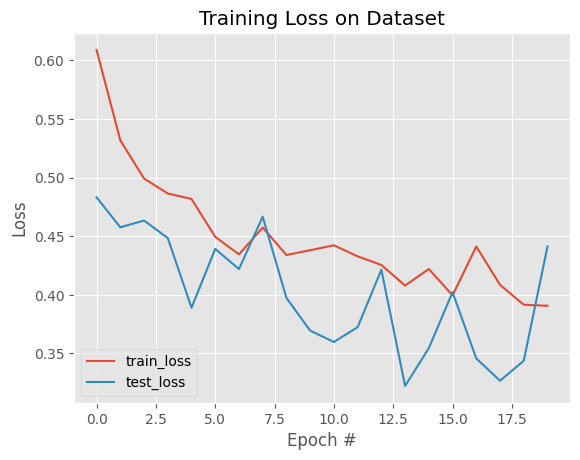

In [32]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

# Exercise 8: Enjoy your results!

Here, we apply the trained model over the test set and we plot the results versus the ground truth mask.

You do not have to do anything, just enjoy!

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [35]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (800, 600))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        filename_mask = filename.split(".jpg")[0] + '.png'
        groundTruthPath = os.path.join(MASK_DATASET_PATH,
          filename_mask)
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (INPUT_IMAGE_WIDTH,
           INPUT_IMAGE_HEIGHT))

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)


# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)

[INFO] loading up test image paths...
[INFO] load up model...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.UNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.UNet])` or the `torch.serialization.safe_globals([__main__.UNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

# EXCERCISE 9: Evaluate your results

Now it's time to evaluate your results! We are going to compute the Intersection over Union (IoU) and the Dice Index.

## Intersection over Union (IoU)

The IoU metric, also known as the Jaccard index, measures the overlap between the predicted segmentation and the ground truth segmentation. It's computed as:

$$\text{IoU} = \frac{|\text{Prediction} \cap \text{Ground Truth}|}{|\text{Prediction} \cup \text{Ground Truth}|}$$

## Dice Index

The Dice coefficient, or Dice similarity coefficient (DSC), is similar to IoU but gives a slightly different perspective:

$$\text{Dice} = \frac{2 |\text{Prediction} \cap \text{Ground Truth}|}{|\text{Prediction}| + |\text{Ground Truth}|}$$

Here you have the code to compute them and an example of it's usage. Write your own code to compute this metrics for your train dataset and your test dataset. Try to modify the functions `compute_iou` and `compute_dice` as little as possible.



In [ ]:
# Helper functions for computing IoU and Dice scores
def compute_iou(pred, target, threshold=0.5, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) score.

    Args:
    pred (torch.Tensor): Predicted segmentation (probabilities or logits).
    target (torch.Tensor): Ground truth segmentation (binary).
    threshold (float): Threshold to binarize the predictions.
    smooth (float): Small value to avoid division by zero.

    Returns:
    float: IoU score.
    """
    pred = (pred > threshold).float()
    intersection = (pred * target).sum((1, 2))
    union = pred.sum((1, 2)) + target.sum((1, 2)) - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou.mean().item()

def compute_dice(pred, target, threshold=0.5, smooth=1e-6):
    """
    Compute the Dice coefficient.

    Args:
    pred (torch.Tensor): Predicted segmentation (probabilities or logits).
    target (torch.Tensor): Ground truth segmentation (binary).
    threshold (float): Threshold to binarize the predictions.
    smooth (float): Small value to avoid division by zero.

    Returns:
    float: Dice coefficient.
    """
    pred = (pred > threshold).float()
    intersection = (pred * target).sum((1, 2))
    dice = (2 * intersection + smooth) / (pred.sum((1, 2)) + target.sum((1, 2)) + smooth)

    return dice.mean().item()

In [ ]:
# Dummy tensors for demonstration
predictions = torch.randn(4, 256, 256)  # Example prediction tensor
ground_truths = torch.randint(0, 2, (4, 256, 256)).float()  # Example ground truth tensor

iou_score = compute_iou(predictions, ground_truths)
dice_score = compute_dice(predictions, ground_truths)

print(f"IoU Score: {iou_score}")
print(f"Dice Score: {dice_score}")

In [ ]:
# Load the image paths
imagePaths = open(TEST_PATHS).read().strip().split("\n")

# Load the model
model = torch.load(MODEL_PATH, map_location=DEVICE)
model.eval()

# Turn off gradient tracking
all_pred_masks = []
all_gt_masks = []

with torch.no_grad():
    for imagePath in imagePaths:
        # Load the image from disk, swap its color channels, cast it to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0

        # Resize the image
        image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))

        # Find the filename and generate the path to ground truth mask
        filename = os.path.basename(imagePath)
        filename_mask = filename.split(".")[0] + '.png'
        groundTruthPath = os.path.join(MASK_DATASET_PATH, filename_mask)

        # Load the ground-truth segmentation mask in grayscale mode and resize it
        gtMask = cv2.imread(groundTruthPath, cv2.IMREAD_GRAYSCALE)
        gtMask = cv2.resize(gtMask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))

        # Preprocess image for model input
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)

        # Make the prediction, pass the results through the sigmoid function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()

        # Filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD).astype(np.uint8) * 255

        # Append the masks to the lists
        all_pred_masks.append(predMask)
        all_gt_masks.append(gtMask)

# Convert lists to tensors
all_pred_masks = torch.tensor(all_pred_masks).float() / 255.0
all_gt_masks = torch.tensor(all_gt_masks).float() / 255.0

# Compute overall IoU and Dice scores
iou_score = compute_iou(all_pred_masks, all_gt_masks)
dice_score = compute_dice(all_pred_masks, all_gt_masks)

print(f"Overall IoU Score: {iou_score:.4f}")
print(f"Overall Dice Score: {dice_score:.4f}")